In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd

import warnings
import logging
import pickle
import os
import gc

# disabling unnecceseray warnings
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow import keras
from keras import layers
import datetime
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

keras.mixed_precision.set_global_policy("mixed_float16")

# Limit the GPU memory growth using TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

import random

# Set random seeds
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)
keras.utils.set_random_seed(random_seed)

!pip install autocorrect
from autocorrect import Speller
spell = Speller(lang='en', fast=True)
spell('helo')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 17.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=e4641ef67e2cf85eaac5a7d7e61e247ec09283fa627028e0866a230f2c2ca332
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


'held'

In [2]:
data_path = '/kaggle/input/commonlit-evaluate-student-summaries/'

# prompts train
train_pro = pd.read_csv(data_path + 'prompts_train.csv')
train_pro.head(1)

# summaries train
train_sum = pd.read_csv(data_path + 'summaries_train.csv')
train_sum.head(1)

# we will need to take a portion of the train data as test data

train = train_pro.merge(train_sum , on = "prompt_id")
train.head(1)

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415


In [3]:
# Model name to load
model_name =  "microsoft/deberta-v3-large"

# Load DeBERTa / RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
pre_trained_model = TFAutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [6]:
# Auto correcting spellings of all summaries
sep = f" {tokenizer.sep_token} "

prefix1 = "Think through this step by step: "
prefix2 = "Pay attention to the content and wording: "

train["text"] = train["text"].apply(lambda x: spell(x))
train['input'] = train['prompt_title'] + sep + prefix1 + train['prompt_question'] + sep + prefix2 + train['text']
train['input'][0]

'On Tragedy [SEP] Think through this step by step: Summarize at least 3 elements of an ideal tragedy, as described by Aristotle. [SEP] Pay attention to the content and wording: 1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad.'

In [ ]:
# Preprocessing features and labels

# Tokenize text data

# Change MAX_SUMMARY_LENGTH
MAX_SUMMARY_LENGTH = 1500 + len(prefix1) + len(prefix2)

# DEBERTA / RoBERTa Tokenizing
X_train = tokenizer.batch_encode_plus(train['input'].tolist(),
                                              add_special_tokens=True,
                                              truncation=True,
                                              padding='max_length',
                                              return_tensors='tf',
                                              max_length=MAX_SUMMARY_LENGTH,
                                              return_attention_mask = True)
del X_train['token_type_ids']

Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

In [9]:
# Create head mask
head_mask = np.zeros(X_train['input_ids'].shape)
for i, summary in enumerate(X_train['input_ids'].numpy()):
    use_full = False
    first_sep_flag = True
    for j, token in enumerate(summary):
        if token == tokenizer.sep_token_id:
            if first_sep_flag:
                first_sep_flag = False
            else:
                use_full = not use_full  
        head_mask[i][j] = (1 if use_full else 0) 
head_mask = tf.constant(head_mask)
head_mask

<tf.Tensor: shape=(7165, 1575), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [10]:
# def get_embeddings(input_ids, attention_mask, model_name):
    
#     # Forward pass through pre trained model
#     outputs = pre_trained_model(input_ids=input_ids, attention_mask=attention_mask)
    
#     if model_name == 'roberta-large':
#         return outputs['pooler_output']
#     else:
#         return outputs[0]

# # Save roberta/deberta embeddings in the training set

# batch_size = 10 # ten is the biggest batch possible (can try maybe 11)
# num_samples = len(X_train['input_ids'])
# num_batches = (num_samples + batch_size - 1) // batch_size
# averaged_embeddings = []

# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, num_samples)
#     inputs = X_train['input_ids'][start_idx: end_idx]
#     masks = X_train['attention_mask'][start_idx: end_idx]
    
#     embeddings = get_embeddings(input_ids=inputs, attention_mask=masks, model_name=model_name)
#     h_mask = tf.expand_dims(tf.cast(head_mask[start_idx: end_idx], dtype=tf.float32), axis=-1)
#     masked_outputs = tf.multiply(embeddings, h_mask)
#     pooled = (tf.reduce_mean(masked_outputs, axis=1)).numpy()
#     averaged_embeddings.append(pooled)
    
#     if i % int(num_batches * 0.1) == 0:
#         print(f"Batch {i}/{num_batches}")
        
#     del embeddings
#     del masked_outputs
#     del pooled
#     del h_mask
#     gc.collect()
#     tf.keras.backend.clear_session()
# # Write to a file    
# concatenated_embeddings = np.concatenate(averaged_embeddings, axis=0)
# with open('masked_pooled_deberta_embeddings.pkl', 'wb') as f:
#     pickle.dump(concatenated_embeddings, f)

In [3]:
# Save file to output folder

# NOTE: if not running on Kaggle then modify the paths

# RoBERTa
# file_path = '/kaggle/input/cls-roberta-embeddings/cls_embeddings.csv' # from input folder

# DeBERTa 
file_path = '/kaggle/input/pooled-deberta-embeddings/pooled_deberta_embeddings.csv'# from input folder

# Load masked pooled Deberta embeddings
with open('/kaggle/input/masked-pooled-deberta-embeddings/mask_pooled_deberta_embeddings.pkl', 'rb') as f:
    loaded_array = pickle.load(f)
    
# Save a csv file
# df_to_save = df_with_embeddings['pooled_roberta_embedding'].apply(lambda x: ','.join(map(str, x)))
# df_to_save.to_csv(file_path, index=False)

# Load embeddings
X_train_preprocessed = pd.read_csv(file_path)

X_train_preprocessed['embeddings'] = X_train_preprocessed['embeddings'].apply(lambda x: list(map(float, x.split(','))))
X_train_preprocessed['masked_embeddings'] = loaded_array.tolist()

In [4]:
# Compile the model (add loss, optimizer, metrics)

# The loss function
def mcrmse(y_true, y_pred):
    columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

initial_learning_rate = 0.00015

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [57]:
# NN with embeddings preprocessed
def create_model():
    input_shape = len(X_train_preprocessed['masked_embeddings'][0])

    input_layer = keras.Input(shape=(input_shape, ), dtype='float32')
    
    layer_norm = layers.LayerNormalization(name='layer_norm1')(input_layer)
    
    reshape_input_layer = layers.Reshape((1,input_shape), name='reshape_layer')(layer_norm)
    
    LSTM_layer = layers.LSTM(512, return_sequences=True, name='LSTM_layer1', activation='linear')(reshape_input_layer)
    
    layer_norm = layers.LayerNormalization(name='layer_norm2')(LSTM_layer)
    
    act = layers.Activation(keras.activations.tanh, name='tanh1')(layer_norm)
    
    LSTM_layer = layers.LSTM(32, return_sequences=False, name='LSTM_layer2', activation='linear',)(act)
    
    layer_norm = layers.LayerNormalization(name='layer_norm3')(LSTM_layer)
    
    act = layers.Activation(keras.activations.tanh, name='tanh2')(layer_norm)
    
    hidden_layer = layers.Dense(16, activation='linear', name='dense_layer')(act)
    
    dropout = layers.Dropout(0.3, name='dropout_layer')(hidden_layer)
    
    # batch_norm = layers.BatchNormalization(name='batch_norm')(dropout)

    output_layer = layers.Dense(2, activation='linear', name='output_layer')(dropout)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    for layer in model.layers:
        layer.trainable = True
        
    opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(loss=mcrmse, optimizer=opt)
    
    return model

model = create_model()
model.summary()

Model: "functional_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_norm1                     │ (None, 1024)           │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer1 (LSTM)              │ (None, 1, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_norm2                     │ (None, 1, 512)         │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh1 (Activation)              │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer2 (LSTM)              │ (None, 32)             │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_norm3                     │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tanh2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,221,234 (12.29 MB)

 Trainable params: 3,221,234 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# # TRAIN PRE-PROCESSED VERSION
# # Train the model

# # model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')
# model = create_model()


X_train_input = np.array(X_train_preprocessed['masked_embeddings'].tolist())
# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

# model.compile(loss=mcrmse,
#               optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate))
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# model.fit(x=X_train_input,
#           y=Y_train,
#           epochs=100,
#           batch_size=16,
#           validation_split=0.2,
#           callbacks=[early_stopping, reduce_lr],
#           verbose=1)

In [59]:
X_train_input = np.array(X_train_preprocessed['masked_embeddings'].tolist())
Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Initialize an empty list to store the validation losses
val_losses = []
histories = []

Y_train_np = Y_train.numpy()

# Iterate over each fold
i = 0
for train_index, val_index in kf.split(X_train_input, Y_train_np):
    
    print(f"Fold {i + 1}")
    i += 1
    
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train_input[train_index], X_train_input[val_index]
    Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
    # Create and compile your model
    model = create_model()
    # model.load_weights('/kaggle/input/best-weights/best.weights.h5')
#     opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
#     model.compile(loss=mcrmse, optimizer=opt)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
                
    # Train the model
    history = model.fit(x=X_train_fold,
                        y=Y_train_fold,
                        epochs=100,
                        batch_size=4,
                        validation_data=(X_val_fold, Y_val_fold),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=2)
    
    # Get the validation loss from the last epoch
    val_loss = min(history.history['val_loss'])
    val_losses.append(val_loss)
    histories.append(history)
    print()

# Calculate the mean validation loss
mean_val_loss = np.mean(val_losses)
print("Mean Validation Loss:", mean_val_loss)

Fold 1
Epoch 1/100
1433/1433 - 13s - 9ms/step - loss: 0.6094 - val_loss: 0.5104 - learning_rate: 1.5000e-04
Epoch 2/100
1433/1433 - 4s - 3ms/step - loss: 0.5349 - val_loss: 0.4958 - learning_rate: 1.5000e-04
Epoch 3/100
1433/1433 - 4s - 3ms/step - loss: 0.5165 - val_loss: 0.4709 - learning_rate: 1.5000e-04
Epoch 4/100
1433/1433 - 4s - 3ms/step - loss: 0.5018 - val_loss: 0.4729 - learning_rate: 1.5000e-04
Epoch 5/100
1433/1433 - 4s - 3ms/step - loss: 0.4875 - val_loss: 0.4634 - learning_rate: 1.5000e-04
Epoch 6/100
1433/1433 - 4s - 3ms/step - loss: 0.4804 - val_loss: 0.4690 - learning_rate: 1.5000e-04
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
1433/1433 - 4s - 3ms/step - loss: 0.4706 - val_loss: 0.4712 - learning_rate: 1.5000e-04
Epoch 8/100
1433/1433 - 4s - 3ms/step - loss: 0.4547 - val_loss: 0.4606 - learning_rate: 7.5000e-05
Epoch 9/100
1433/1433 - 4s - 3ms/step - loss: 0.4469 - val_loss: 0.4590 - learning_rate: 7.5000e-05
Epoch 10/100
14

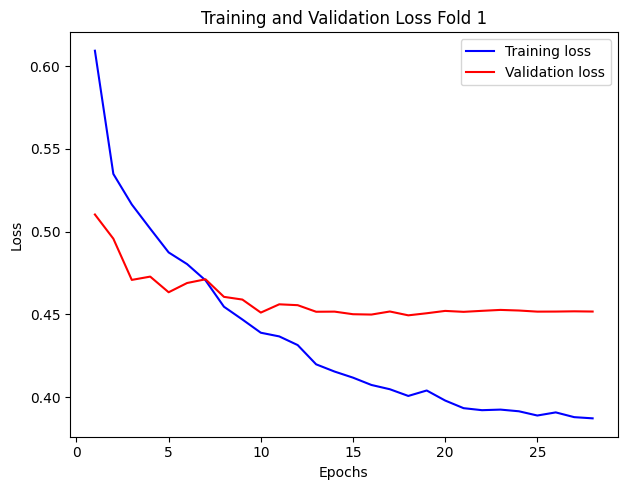

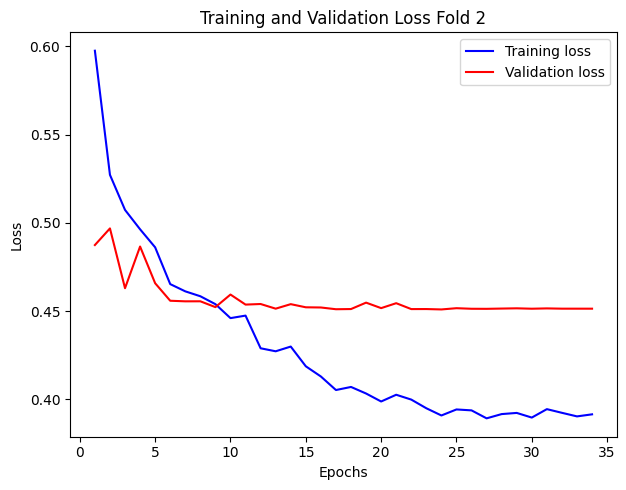

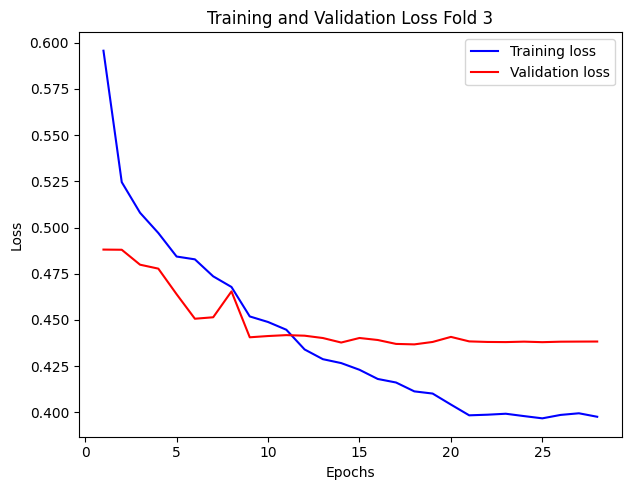

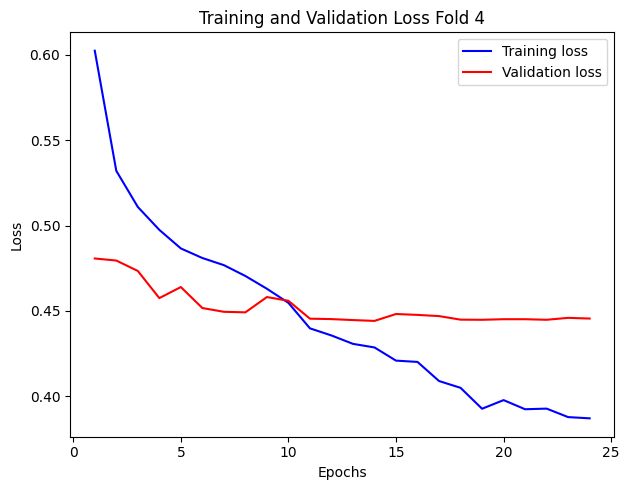

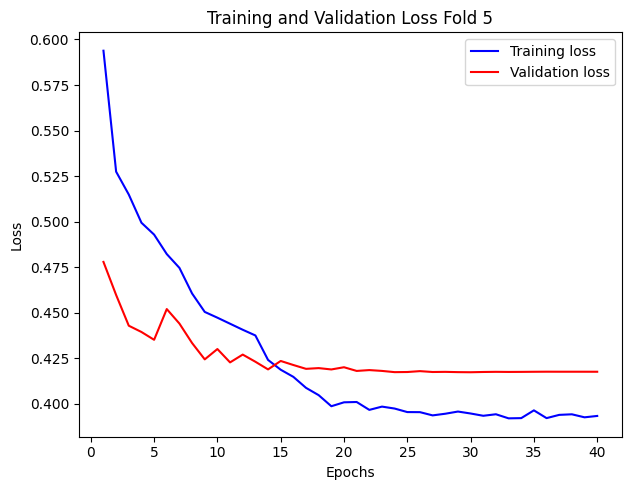

In [60]:
# Extracting training history
for i, history in enumerate(histories):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    epochs = range(1, len(train_losses) + 1)

    # Plotting losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss Fold {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# # Create a layer that wraps the RoBERTa model to support Keras library
# class PreTrainedModel(layers.Layer):
#     def __init__(self, pre_trained_model,trainable=False, **kwargs):
#         super().__init__(**kwargs)
#         self.pre_trained_model = pre_trained_model
#         self.pre_trained_model.trainable = trainable

#     def call(self, inputs):
#         input1 = inputs[0]
#         input2 = inputs[1]

#         # Call the roberta model and get the last hidden state
#         output = self.pre_trained_model(input_ids=input1,
#                                                 attention_mask=input2)
#         del input1
#         del input2
#         gc.collect()
        
#         return output[0]

In [18]:
# # Define keras neural network with Functional API

# # Explanation of the Functional API: 
# # For every layer we specify between parentheses at the end of the line the previous layer which will be the input.

# input_layer = keras.Input(shape=(1, MAX_SUMMARY_LENGTH, 1024), dtype='float32')

# input_layer2 = keras.Input(shape=(2,), dtype='float32')

# reshape = layers.Reshape((MAX_SUMMARY_LENGTH, 1024))(input_layer)
# # embeddings = PreTrainedModel(pre_trained_model)([input_layer1, input_layer2])
# global_avg_pooling = layers.GlobalAveragePooling1D()(reshape)

# hidden_layer = layers.Dense(256, activation='linear')(global_avg_pooling)
# batch_norm = layers.BatchNormalization()(hidden_layer)
# output_layer = layers.Dense(2, activation='linear')(batch_norm)

# # Define the model
# model = keras.Model(inputs=[input_layer, input_layer2], outputs=output_layer)

# # Make roberta params untrainable
# # for layer in model.layers[:-4]:
# #     layer.trainable = False
    
# model.summary()

In [19]:
# # Compile the model (add loss, optimizer, metrics)

# # The loss function
# def mcrmse(y_true, y_pred):
#     columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
#     return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

# initial_learning_rate = 0.001
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# model.compile(loss=mcrmse,
#               optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
#               # metrics=['r2_score']
#              )


In [20]:
# model.fit(train_dataset,
#           epochs=10,
#           validation_data=val_dataset,
#           callbacks=[early_stopping],
#           verbose=1)

In [21]:
# Train the model

In [22]:
# # Clear any logs from previous runs
# # !rm -rf ./logs/
# num_of_samples = 10

# inputs = X_train['input_ids']
# masks = X_train['attention_mask']

# # Train the model

# # model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')
# model.fit(x=[inputs, masks],
#           y=Y_train,
#           epochs=5,
#           batch_size=16,
#           validation_split=0.2,
#           callbacks=[tensorboard_callback, early_stopping],
#           verbose=2)

# # Create the 'model' directory if it does not exist
# if not os.path.exists('model'):
#     os.makedirs('model')

In [23]:
# model.save_weights('model/saved_model_weights.weights.h5')

In [24]:
# !rm -rf ./logs/fit

In [25]:
# import shutil
# # Zip the logs directory for downloading it locally 
# shutil.make_archive("/kaggle/working/logs", "zip", "./logs")
# shutil.make_archive("/kaggle/working/model", "zip", "./model")

In [26]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [27]:
# Reload the TensorBoard notebook extension if needed
# %reload_ext tensorboard

In [28]:
# http://localhost:6006/
# %tensorboard --logdir logs/fit --port=6006

In [29]:
# Demo of the model

In [30]:
# model.load_weights('/kaggle/input/model-weights/saved_model_weights.weights.h5')

In [31]:
# def eval_summary(prompt, question, summary):
#     spell(summary)
#     sample = prompt + sep + question + sep + summary
#     tokenized_summary = tokenizer(sample,
#                                   add_special_tokens=True,
#                                   truncation=True,
#                                   padding='max_length',
#                                   return_tensors='tf',
#                                   max_length=MAX_SUMMARY_LENGTH,
#                                   return_attention_mask = True)

#     output = model([tokenized_summary['input_ids'], tokenized_summary['attention_mask']])
#     print(f"Content: { output[0][0]} \nWording: {output[0][1]}")
#     # return output[0][0], output[0][1]

In [32]:
# Input Demo 
# sample_index = 8
# prompt = train['prompt_title'][sample_index]
# question = train['prompt_question'][sample_index]
# summary = train['text'][sample_index]
# print(f"prompt: {prompt}\n")
# print(f"question: {question}\n")
# print(f"summary: {summary}")

In [33]:
# # Output of the model
# print('Predicted Scores:')
# eval_summary(prompt, question, summary)

# # Real Scores
# print(f"\nReal Scores:\nContent: {train['content'][sample_index]}\nWording: {train['wording'][sample_index]}")